In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import os
import argparse
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F
import copy
from PIL import Image
import matplotlib.pyplot as plt
import json
from collections import OrderedDict

In [3]:
data_dir = 'dataset'
train_dir = data_dir + '/train' #70% del banco de datos
valid_dir = data_dir + '/valid' #15% del banco de datos
test_dir = data_dir + '/test' #15% del banco de datos

In [4]:

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=8)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8)

#TODO: Know your data
dataset_sizes = {'train': len(train_data), 'valid': len(valid_data), 'test': len(test_data)}
class_names = train_data.classes

print ("Dadaset Size: "+ str(dataset_sizes) + "\n")
n_class = len(class_names)
print ("Number of classes: "+ str(n_class) + "\n")
print ("Classes: "+ str(class_names) + "\n")

Dadaset Size: {'train': 40698, 'valid': 8721, 'test': 8721}

Number of classes: 2

Classes: ['Barcos', 'Nobarcos']



### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('data.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
#SE CARGA EL MODELO DE RED NEURONAL CONVOLUCIONAL

model = models.vgg16(pretrained=True)
model
for param in model.parameters():
    param.requires_grad = False

features = int(model.classifier[0].in_features)

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(features, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [6]:
#SE ENTRENA LA RED
use_gpu = torch.cuda.is_available()
#model = model.to(device)

if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 10
dataloaders = {'train': trainloader, 'valid': validloader, 'test': testloader}
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
        if phase == 'train':
            scheduler.step()
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            # get the inputs
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            # statistics
            #running_loss += loss.data[0] * inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        # deep copy the model
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()
print('Best val Acc: {:4f}'.format(best_acc))
# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/9
----------
train Loss: 0.4270 Acc: 0.8017
valid Loss: 0.2962 Acc: 0.8805

Epoch 1/9
----------
train Loss: 0.3811 Acc: 0.8275
valid Loss: 0.2981 Acc: 0.8790

Epoch 2/9
----------
train Loss: 0.3694 Acc: 0.8367
valid Loss: 0.3033 Acc: 0.8579

Epoch 3/9
----------
train Loss: 0.3649 Acc: 0.8380
valid Loss: 0.2604 Acc: 0.8944

Epoch 4/9
----------
train Loss: 0.3617 Acc: 0.8394
valid Loss: 0.2707 Acc: 0.8852

Epoch 5/9
----------
train Loss: 0.3518 Acc: 0.8461
valid Loss: 0.2879 Acc: 0.8764

Epoch 6/9
----------
train Loss: 0.3522 Acc: 0.8459
valid Loss: 0.2873 Acc: 0.8691

Epoch 7/9
----------
train Loss: 0.3308 Acc: 0.8544
valid Loss: 0.2659 Acc: 0.8858

Epoch 8/9
----------
train Loss: 0.3297 Acc: 0.8556
valid Loss: 0.2696 Acc: 0.8812

Epoch 9/9
----------
train Loss: 0.3257 Acc: 0.8569
valid Loss: 0.2539 Acc: 0.8928

Best val Acc: 0.894393


## Testing the network

In [7]:
loss_fn = nn.NLLLoss()
model.eval()

accuracy = 0
test_loss = 0
for ii, (images, labels) in enumerate(dataloaders['test']):
    # Set volatile to True so we don't save the history
    if use_gpu:
        inputs = Variable(images.cuda(), volatile=True)
        labels = Variable(labels.cuda(), volatile=True)
    else:
        inputs = Variable(images, volatile=True)
        labels = Variable(labels, volatile=True)
    output = model.forward(inputs)
    test_loss += loss_fn(output, labels).data[0]

    ## Calculating the accuracy 
    # Model's output is log-softmax, take exponential to get the probabilities
    ps = torch.exp(output).data
    # Class with highest probability is our predicted class, compare with true label
    equality = (labels.data == ps.max(1)[1])
    # Accuracy is number of correct predictions divided by all predictions, just take the mean
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Batch: {} ".format(ii+1),
     "Test Loss: {:.3f}.. ".format(test_loss/len(dataloaders['test'])),
     "Test Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Batch: 1091  Test Loss: 0.274..  Test Accuracy: 0.891


In [8]:
# TODO: Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
              'output_size': 2,
              'batch_size': dataloaders['train'].batch_size,
              'state_dict': model.state_dict(),
              'optimizer_dict':optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
              'epoch': model.epochs
             }
torch.save(checkpoint, 'checkpoint.pth')

In [7]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.vgg16()  
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(features, 500)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(500, 2)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Testing checkpoint
dataloaders = {'train': trainloader, 'valid': validloader, 'test': testloader}
loaded_model.eval()
images, labels = next(iter(dataloaders['test']))
output = loaded_model.forward(Variable(images[:2]))
ps = torch.exp(output).data

In [8]:
def process_image(image): 
    # TODO: Process a PIL image for use in a PyTorch model
    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [9]:
def imshow(image, ax=None, title=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [10]:
def predict(image_path, model, topk=2):

    # TODO: Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

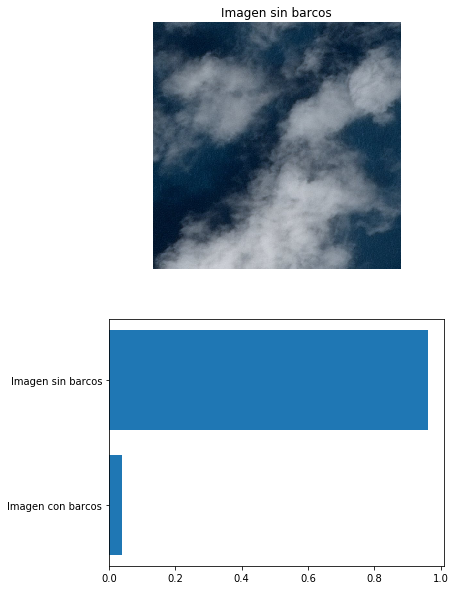

In [12]:
# TODO: Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

img = 'C:/Users/usuario/Desktop/Kaggle ships/BALANCEADO/dataset/test/Nobarcos/00d89dfdc.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)